# FOOTPRINTS

In [7]:
import numpy as np
import datetime
from datetime import date
import json
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

In [8]:

def leer_data():
    outfile='./SOURCES/data.csv'
    data = pd.read_csv(outfile)
    return data

data_original = leer_data()
data_original.head(3)

,client_id,date,año,mes,dia,hora,merchant_departement,merchant_province,merchant_district,mcc,mccg,client_age,quantity,amount_sol,dia_semana,turno
0,NNeQwQy9MAQ=,2016-07-15 22:23:25,2016,7,15,22,LIMA,LIMA,San Juan De Luriganc,7994,2,33.0,1,100.0,Fri,4-Noche
1,qFRoPHPOc/I=,2016-06-21 21:30:55,2016,6,21,21,LIMA,LIMA,San Juan De Luriganc,7994,2,52.0,1,20.0,Tues,4-Noche
2,qFRoPHPOc/I=,2017-02-01 01:29:59,2017,2,1,1,LIMA,LIMA,San Juan De Luriganc,7994,2,52.0,1,100.0,Weds,1-Madrugada


In [9]:
mccgs = ((data.groupby(['mccg'], as_index=False, sort=True)).count())['mccg']
mccgs,mccgs[3],len(mccgs)

(0    2
 1    3
 2    4
 3    5
 Name: mccg, dtype: int64, 5, 4)

# RESULTADOS

## Unimos los resultados por cada mccg

In [17]:


path='./RESULTS' 
file='./RESULTS/U' 
footprint="%s.footprint" %(file)
individual_clusters="%s.individual_footprint.clusters" %(file)
individual_labels="%s.individual_footprint.labels" %(file)   
collective_clusters="%s.collective_footprint.clusters" %(file)
collective_labels="%s.collective_footprint.labels" %(file)
    
# Unimos
footprint = pd.read_csv(footprint, sep=",", header=0)
footprint.rename(columns={'customer_id':'customer_tag'}, inplace=True)     
individual_labels = pd.read_csv(individual_labels, sep=";", header=0, index_col=False)
collective_labels = pd.read_csv(collective_labels, sep=";", header=0, index_col=False)

result = pd.merge(individual_labels, collective_labels, on=['customer_tag', 'individual_cluster'])
result = result.iloc[:, :(-1*4*7*len(mccgs))]
result= pd.merge(footprint, result, on=['customer_tag','year', 'week'])
result1 = result.iloc[:, :(-1*4*7*len(mccgs)-1)]
result = pd.concat([result1, result[['collective_cluster']]], axis=1)
result[['year','week','profile_id','size','individual_cluster','collective_cluster']] = result[['year','week','profile_id','size','individual_cluster','collective_cluster']].astype(int)

path_res='%s/Results.csv' %(path)
result.to_csv(path_res,index=False)
print('Done')

Done


## Graficos

### Numero de Clusters por  mccg

=>   16  clusters


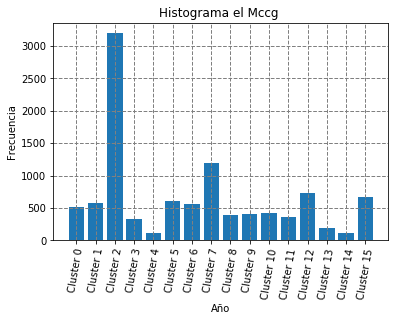

Done


In [20]:

path_res='%s/Results.csv' %(path)
    
result = pd.read_csv(path_res, sep=",", header=0)
    
nn= result.groupby(['collective_cluster'], as_index=False, sort=True)['customer_tag'].count()
print("=>  ",str(len(nn))," clusters")
fig, ax = plt.subplots()
ax.bar(nn.index, nn['customer_tag'], align='center')
ax.grid(color='gray', linestyle='--', linewidth=1)

ax.set_xlabel('Año')
ax.set_xticks(nn.index)

ax.set_ylabel('Frecuencia')
tag =[]
for j in range(len(nn)):
    temp = 'Cluster '+ str(j)+''
    tag.append(temp)

ax.set_xticklabels(tag, rotation=80)
    
title = "Histograma el Mccg "
ax.set_title(title)
plt.show()

print('Done')

### Comportamiento de los clusters en el Tiempo

In [ ]:
from datetime import datetime
def fromisocalendar(y,w,d):
    date = datetime.strptime( "%04dW%02d-%d"%(y,w-1,d), "%YW%W-%w")
    aa = date.year
    mm = date.month
    dd = date.day
    return str(aa)+"-"+str(mm)+"-"+str(dd) 

import matplotlib._color_data as mcd
box = dict(facecolor='#cccc00', pad=4, alpha=0.8)

for i in range(len(mccg)):
#for i in range(1):

    path = "RESULTS/MCCG_"+str(mccg[i])
    path_res='./%s/mccg_%s_results.csv.json' %(path,mccg[i])
    
    result = pd.read_csv(path_res, sep=",", header=0)
    
    hist = result.groupby(['collective_cluster'], as_index=False, sort=True)['customer_tag'].count()
    longitud = len(hist)
    helper = result.groupby(['year','week','collective_cluster'], as_index=False, sort=True)['customer_tag'].count()
    helper['fecha'] = helper['year'].astype(str).str.cat(helper['week'].astype(str), sep='-')
    helper = helper[['fecha','collective_cluster','customer_tag']]
    helper_1 = helper.groupby(['fecha']).count()
    helper_1['fecha'] = helper_1.index
    
    fig = plt.figure(figsize=(18,4))
    ax = fig.add_subplot(111, frameon=True)
    x = list(helper['fecha'].drop_duplicates())
    x1 = x
    for j in range(len(x)):
        x1[j] = fromisocalendar(int(x[j][:4]),int(x[j][5:len(x[j])]),2)

        
    ax.set_xticklabels(x, rotation=80)

    # ------------ COLORES ---------------------
    overlap = mcd.XKCD_COLORS
    colores = ["" for x in range(len(overlap))]
    for j, n in enumerate(sorted(overlap, reverse=True)):
        cor = mcd.XKCD_COLORS[n].upper()
        colores[j] = cor

    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

    from datetime import datetime

    for k in range(longitud):
        cluster_k = helper[helper['collective_cluster']==k]
        cluster_k1 = helper_1.set_index('fecha').join(cluster_k.set_index('fecha'), lsuffix='_x', rsuffix='_y')
        cluster_k1 = cluster_k1[['customer_tag_y']]
        cluster_k1 = cluster_k1.fillna(0)
        y = cluster_k1['customer_tag_y']
        #x = cluster_k1.index
        ax.plot(x,y,'--',color=colores[k*9],label="Comportamiento "+str(k))

    
    
    ax.legend()
    title = 'Variacion en el tiempo del comportamiento de compra para el Mccg '+str(mccg[i])
    ax.set_title(title)
    ax.set_xlabel('Año - Semana (Fecha)', bbox=box)
    ax.set_ylabel('Cantidad de Clientes', bbox=box)

print('Done')

In [ ]:
mccg_deseado = 2

# for i

path = "RESULTS/MCCG_"+str(mccg_deseado)
path_res='./%s/mccg_%s_results.csv.json' %(path,mccg_deseado)
    
result = pd.read_csv(path_res, sep=",", header=0)

# Numero de cluster
cluster = result.groupby(['collective_cluster']).sum()
cluster = cluster.iloc[:, 5:-1]
num_cluster= len(cluster)

for j in range(num_cluster):
    cluster_i = cluster[cluster.index == j]
    df0 = cluster_i.iloc[:, 0:7] 
    df1 = cluster_i.iloc[:, 7:14]
    df2 = cluster_i.iloc[:, 14:21]
    df3 = cluster_i.iloc[:, 21:28]

    df0 = df0.transpose().reset_index(drop=True).transpose()
    df1 = df1.transpose().reset_index(drop=True).transpose()
    df2 = df2.transpose().reset_index(drop=True).transpose()
    df3 = df3.transpose().reset_index(drop=True).transpose()

    dfs = [df0,df1,df2,df3]
    df = pd.concat( dfs,axis=0,ignore_index=True)
    df.columns = ['Lun','Mar', 'Mie','Jue','Vie','Sab','Dom']
    df.index = ['Madrugada','Mañana', 'Tarde','Noche']
    
    m = np.around(df.values,2)
    vals = np.around(df.values/(cluster_i.values).mean(),2)
    normal = plt.Normalize(vals.min()-1, vals.max()+1)

    fig = plt.figure(figsize=(12,1))
    
    ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
    ax.set_title('Representación del Cluster: %s'%(j))
    the_table=plt.table(cellText=m, rowLabels=df.index, colLabels=df.columns, 
                        colWidths = [0.123]*vals.shape[1], loc='upper center', 
                        cellColours=plt.cm.PuBu(normal(vals)))